# Random Forest Model

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Data Exploration

In [4]:
path = '../../data_20210213_1406_____USE_THIS_latest_version/train_20210213_1406_NAmean.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 196 entries, Unnamed: 0 to MiscFeature_nan
dtypes: float64(4), int64(192)
memory usage: 2.2 MB


In [9]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=123)
print(df_train.shape)
print(df_test.shape)

(1168, 196)
(292, 196)


In [10]:
# select important features (as per data exploration research findings)
df_train = df_train[["OverallQual", "GrLivArea", "TotalBsmtSF", "2ndFlrSF", "GarageCars", "SalePrice"]]
df_train.head()

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,GarageCars,SalePrice
318,7,2646,1347,1274,3,260000
580,6,1429,1144,0,2,181900
961,6,2872,1330,1330,2,272000
78,4,1768,1768,0,0,136500
5,5,1362,796,566,2,143000


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

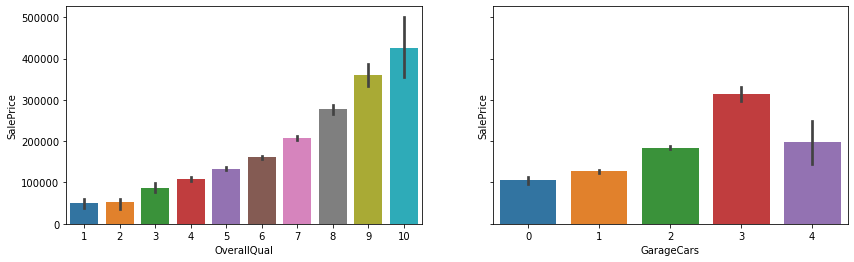

In [12]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=True)

bp1 = sns.barplot(data=df_train, x='OverallQual', y='SalePrice', ax=ax1)
bp2 = sns.barplot(data=df_train, x='GarageCars', y='SalePrice', ax=ax2)

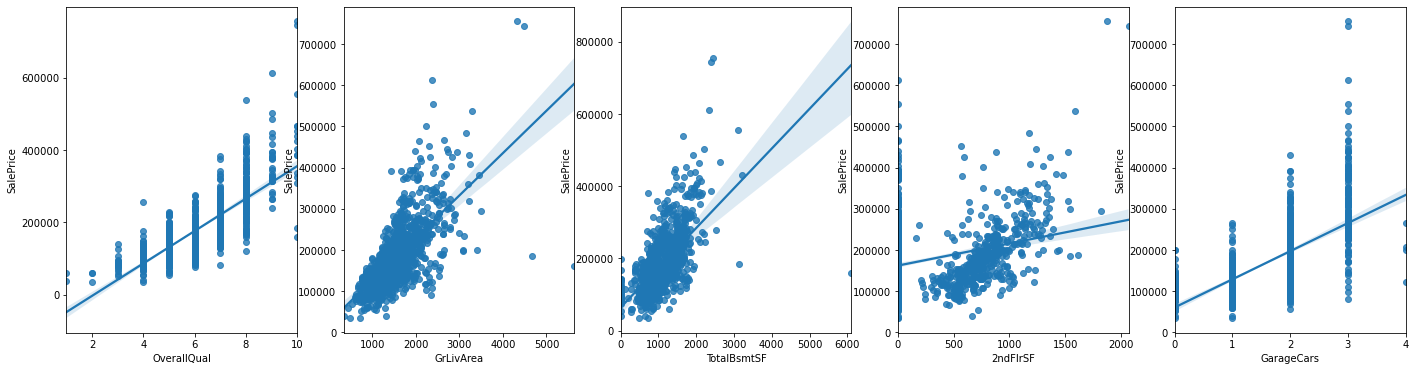

In [36]:
fig, axs = plt.subplots(ncols=5)
fig.set_size_inches(24, 6)
sns.regplot(x='OverallQual', y='SalePrice', data=df_train, ax=axs[0])
sns.regplot(x='GrLivArea', y='SalePrice', data=df_train, ax=axs[1])
sns.regplot(x='TotalBsmtSF',y='SalePrice', data=df_train, ax=axs[2])
sns.regplot(x='2ndFlrSF', y='SalePrice', data=df_train, ax=axs[3])
sns.regplot(x='GarageCars', y='SalePrice', data=df_train, ax=axs[4])

plt.show()

## Train-Test Split

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
x = df[["OverallQual", "GrLivArea", "TotalBsmtSF", "2ndFlrSF", "GarageCars"]]
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=123)
print(X_train.shape)
print(X_test.shape)

(1168, 5)
(292, 5)


## Model Training

In [42]:
model = RandomForestRegressor(random_state=123)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [14]:
from sklearn.metrics import r2_score, mean_squared_error

In [44]:
preds = model.predict(X_test)

## Evaluate Metrics

In [52]:
r2 = r2_score(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

R^2: 0.8601518671561074
RMSE: 29397.4083443447


In [54]:
print(f'Min SalePrice: {y_test.min()}')
print(f'Max SalePrice: {y_test.max()}')

Min SalePrice: 37900
Max SalePrice: 625000


[Text(0.5, 0, 'True SalePrice'), Text(0, 0.5, 'Predicted SalePrice')]

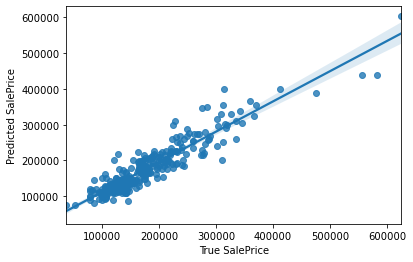

In [57]:
rp = sns.regplot(x=y_test, y=preds)
rp.set(xlabel='True SalePrice', ylabel='Predicted SalePrice')

## Save Model

In [27]:
import pickle

In [59]:
with open('houseprice_model_rf.pkl', 'wb') as file:
    pickle.dump(model, file)

This model can now be used by a web app, such as a Flask webserver.

# Hyperparameter Optimisation with Cross Validation

In [11]:
# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

n_features = X_train.shape[1]
n_samples = X_train.shape[0]
grid = RandomizedSearchCV(RandomForestRegressor(random_state=123), 
                       n_jobs=-1,
                       cv=3,
                       verbose=2,
                       param_distributions={
                         'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
                        })
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.8s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [12]:
grid.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      n_estimators=600, random_state=123)

In [13]:
print('Train R^2 Score : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test R^2 Score : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Train R^2 Score : 0.936
Test R^2 Score : 0.862
Best R^2 Score Through Grid Search : 0.788
Best Parameters :  {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [15]:
preds = grid.best_estimator_.fit(X_train, y_train).predict(X_test)
print(f"R^2: {r2_score(y_test, preds)}")
print(f"RMSE: {mean_squared_error(y_test, preds, squared=False)}")

R^2: 0.8618569766588114
RMSE: 29217.643593040753


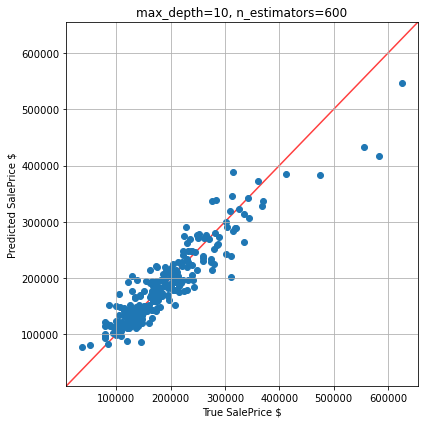

In [26]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, preds)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_xlabel('True SalePrice \$')
ax.set_ylabel('Predicted SalePrice \$')
ax.set_title('max_depth=10, n_estimators=600')
# now plot both limits against eachother
ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid(True)

plt.tight_layout()
plt.savefig('rf_perform.png')

In [28]:
with open('houseprice_model_rf.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)